# RANS from DNS

Our goal here, in general, is to find new valid equations that describe fluid flow. 
We will try to find new closures for the steady RANS equations based on direct numerical
simulation (DNS) of a boundary layer.


## Steady RANS equations with generic Reynolds stress effects

$$
(\vec{U} \cdot \nabla) \vec{U}
+ \frac{1}{\rho} \nabla P 
- \nu \nabla^2 \vec{U}
= \mathbf{R},
$$

where in this case $\mathbf{R}$ is simply the effects of the Reynolds stresses (i.e., the opposite of the gradient), not the Reynolds stresses themselves.

Some ideas for what $\mathbf{R}$ could be:

$$
\mathbf{R} = A\nabla P^2 + B\nabla K + C \nabla \times \vec{U} 
    + D\nabla(\nabla \times \vec{U})^2
    + E \vec{U}
$$


## Algorithm

1. Pick terms (in addition to non-Reynolds stress Navier--Stokes terms).
2. Create a random list of points in space that is at least as large as the number
   of terms.
3. At each point, acquire all data for all terms for all times.
4. Average data at each point for all times.
5. Solve for coefficients using a linear model.

## Terms

$$
U \frac{\partial U}{\partial x} 
+ V \frac{\partial U}{\partial y} + W \frac{\partial U}{\partial z}
+ \frac{1}{\rho}\frac{\partial P}{\partial x} 
- \nu \left( 
    \frac{\partial^2 U}{\partial x^2}
    + \frac{\partial^2 U}{\partial y^2} 
    + \frac{\partial^2 U}{\partial z^2} 
\right)
$$

$$
= 
A \left( \frac{\partial U}{\partial x} \right)^2 
+ B \left( \frac{\partial U}{\partial y} \right)^2
+ C \left( \frac{\partial U}{\partial z} \right)^2
+ D \left( \frac{\partial P}{\partial x} \right)^2
+ E \frac{\partial^2 P}{\partial x^2}
+ F U \frac{\partial P}{\partial x}
$$

$$
U \frac{\partial V}{\partial x} 
+ V \frac{\partial V}{\partial y} 
+ W \frac{\partial V}{\partial z}
+ \frac{1}{\rho}\frac{\partial P}{\partial y} 
- \nu \left( 
    \frac{\partial^2 V}{\partial x^2}
    + \frac{\partial^2 V}{\partial y^2} 
    + \frac{\partial^2 V}{\partial z^2} 
\right)
$$

$$
= 
A \left( \frac{\partial V}{\partial x} \right)^2 
+ B \left( \frac{\partial V}{\partial y} \right)^2
+ C \left( \frac{\partial V}{\partial z} \right)^2
+ D \left( \frac{\partial P}{\partial y} \right)^2
+ E \frac{\partial^2 P}{\partial y^2}
+ F V \frac{\partial P}{\partial y}
$$

## Terms in index notation

To be general and consistent, since we don't have any x- or z-variation

$$
\frac{\partial U_i}{\partial t} + U_j \frac{\partial U_i}{\partial x_j} 
+ \frac{1}{\rho}\frac{\partial P}{\partial x_i}
- \nu \frac{\partial ^2 U_i}{\partial x_j x_j}
=
A \frac{(\partial U_i)^2}{\partial x_j \partial x_j}
+ B \frac{\partial U_j U_j}{\partial x_i}
+ C \frac{\partial P^2}{\partial x_i}
+ D \left( \frac{\partial P}{\partial x_i} \right)^2
+ E U_j \frac{\partial P}{\partial x_j}
$$

What these coefficients describe:

* $A$: The square of the velocity gradient
* $B$: The gradient of kinetic energy
* $C$: The gradient of squared pressure
* $D$: The square of the pressure gradient

,y/d99,y+,uv,uw,vw,umed,vmed,wmed,dumdy,dvmdy,dwmdy,oxmed,oymed,ozmed,pm,pp,y
y,,,,,,,,,,,,,,,,,
0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1.000017,-4.849432e-10,-0.001014,-0.001014,0.000000e+00,-1.000017,0.000529,3.032713,0.000000
0.002241,0.000145,0.288859,-0.000027,-0.000020,3.663793e-08,0.288859,5.517880e-08,-0.000293,0.999980,3.826547e-07,-0.001014,-0.001014,-5.526411e-08,-0.999980,0.000529,3.030068,0.002241
0.005143,0.000333,0.662932,-0.000337,-0.000110,4.568896e-07,0.662892,2.913277e-07,-0.000672,0.999738,8.802282e-07,-0.001014,-0.001014,-1.268852e-07,-0.999738,0.000529,3.028187,0.005143
0.008698,0.000564,1.121292,-0.001671,-0.000327,2.301801e-06,1.120913,8.350829e-07,-0.001137,0.998564,1.492937e-06,-0.001012,-0.001012,-2.148001e-07,-0.998564,0.000528,3.027302,0.008698
0.012900,0.000836,1.663030,-0.005539,-0.000751,7.686887e-06,1.661029,1.840536e-06,-0.001684,0.994960,2.218613e-06,-0.001007,-0.001007,-3.188665e-07,-0.994960,0.000528,3.027948,0.012900


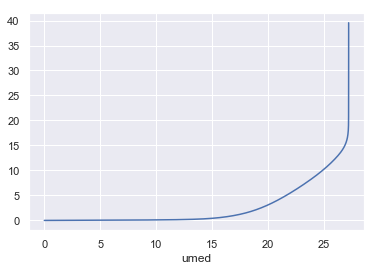

In [26]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import seaborn
seaborn.set()

# Write a function to load the data
def load_data(re=6500, drop_aux_cols=True):
    fpath = f"data/Re_theta.{re:4d}.prof"
    # First read delta 99 and column names
    with open(fpath) as f:
        for n, line in enumerate(f.readlines()):
            line = line.split()
            if len(line) > 1:
                if line[1].startswith("delta_99="):
                    d99 = float(line[1].replace("delta_99=", ""))
                elif line[1].startswith("y/d99"):
                    cols = line[1:]
                    skiprows = n + 1
    df = pd.read_csv(fpath, names=cols, skiprows=skiprows,
                     delim_whitespace=True)
    df["y"] = df["y/d99"] * d99
    # Drop columns we won't be using
    if drop_aux_cols:
        df = df[[c for c in df.columns if "rms" not in c
                 and "3" not in c and "2" not in c]]
    return df.set_index("y", drop=False)


df = load_data()

df.plot(x="umed", y="y", legend=False)

df.head()

## Using data from pyJHTDB

1. Pick a bunch of points randomly throughout the domain, at least more than the number of terms we want to test.
2. Add points in each direction for computing spatial derivatives.
3. Get $\vec{u}$, $p$, and their gradients for all time at all points in the list.
4. Calculate terms based on mean values.
5. Use a regression model to determine coefficients on each term.
6. Repeat this process to ensure the coefficients don't change?
7. Run a RANS simulation with this new model and check the results against the mean profiles.

In [1]:
import pyJHTDB

# Get data


In [1]:
import pandas as pd

In [2]:
df = pd.read_hdf("data/jhtdb-transitional-bl/time-ave-profiles.h5")

ValueError: No dataset in HDF5 file.

In [3]:
import h5py

In [18]:
with h5py.File("data/jhtdb-transitional-bl/time-ave-profiles.h5", "r") as f:
    print(f.keys())
    data = {}
    for k in f.keys():
        data[k] = f[k][()]

<KeysViewHDF5 ['pm', 'ppm', 'um', 'upm', 'uum', 'uvm', 'uwm', 'vm', 'vpm', 'vvm', 'vwm', 'wm', 'wpm', 'wwm', 'x_coor', 'y_coor', 'z_coor']>


In [24]:
x = data["x_coor"]
y = data["y_coor"]
z = data["z_coor"]
um = data["um"]
x.shape, y.shape, z.shape, um.shape

((3320,), (224,), (2048,), (224, 3320))

In [17]:
um.shape

(224, 3320)

In [30]:
df = pd.DataFrame(columns=x, index=y, data=um)
df.columns.name = "x"
df.index.name = "y"

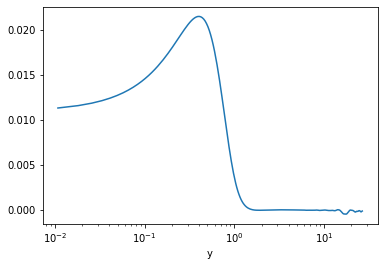

In [33]:
df[df.columns[5]].diff().plot(logx=True)